In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from scipy import stats

In [44]:
def log2_transform_ratios(df, baseline):
    """
    Applies a log2 transformation to the data columns of a DataFrame after dividing by a baseline value and adding 1.

    Args:
    df (pd.DataFrame): the first column is an identifier and is not transformed; all other columns are transformed
    baseline (float): pivot point to subtract from each data value

    Returns:
    pd.DataFrame: DataFrame with transformed data columns
    """
    data_columns = df.columns[1:]  # first column is ID_REF
    df[data_columns] = df[data_columns].divide(baseline) + 1
    df[data_columns] = df[data_columns].applymap(np.log2)
    
    return df

In [3]:
!ls ./microarray

178238387		       human_embryonic_stem_cells.csv
GSE65211_series_matrix.txt.gz  human_pbmc.csv
GSE79269_series_matrix.txt.gz  kidney_control_values_gene.csv
H0351.2001		       liver_control_values_gene.csv
human_brain.csv		       lung_control_values_gene.csv


In [4]:
dir = "/microarray/"

In [5]:
n_bins = 10

## Mouse microarrays

Load and inspect the data

In [6]:
kidney_data = pd.read_csv(dir+"kidney_control_values_gene.csv")
liver_data = pd.read_csv(dir+"liver_control_values_gene.csv")
lung_data = pd.read_csv(dir+"lung_control_values_gene.csv")
gene_lengths = pd.read_csv("mouse_gene_lengths_exons.txt", sep='\t', names=['ID', 'Length'])

In [7]:
gene_lengths['ID'] = gene_lengths['ID'] #.str.split(".").str[0]

In [8]:
mapping = pd.read_csv("mouse_t2g_nac.txt", sep='\t', names=['transcript_ID', 'gene_ID', 'gene_symbol', 'transcript_name', 'chr', 'transcript_start', 'transcript_end', 'strand'], low_memory=False)
mapping = mapping.drop(columns=['transcript_ID', 'transcript_name', 'chr', 'transcript_start', 'transcript_end', 'strand'])
mapping = mapping.drop_duplicates()

In [9]:
merged = pd.merge(mapping, gene_lengths, left_on='gene_ID', right_on='ID', how='inner')

### Mouse kidney

In [10]:
kidney_merged = pd.merge(kidney_data, merged, left_on=['Symbol'], right_on=['gene_symbol'], how='inner')
kidney_merged["Length"] = kidney_merged["Length"].astype(float)
kidney_merged["MeanIntensity"] = kidney_merged[["kidney_normal_batch1_rep1", "kidney_normal_batch1_rep2", "kidney_normal_batch2"]].mean(axis=1)

In [11]:
kidney_merged.dropna(subset=["Length"], inplace=True)
bins, bin_edges = pd.qcut(kidney_merged["Length"], n_bins, labels=False, retbins=True)

bin_labels = []
for i in range(len(bin_edges)-1):
    bin_label = f"{round(bin_edges[i])}-{round(bin_edges[i+1])}bp"
    bin_labels.append(bin_label)
    print(f"Bin {i}: {bin_label}")

kidney_merged["BinnedLength"] = bins

Bin 0: 105-878bp
Bin 1: 878-1104bp
Bin 2: 1104-1314bp
Bin 3: 1314-1519bp
Bin 4: 1519-1762bp
Bin 5: 1762-2011bp
Bin 6: 2011-2335bp
Bin 7: 2335-2766bp
Bin 8: 2766-3527bp
Bin 9: 3527-18845bp


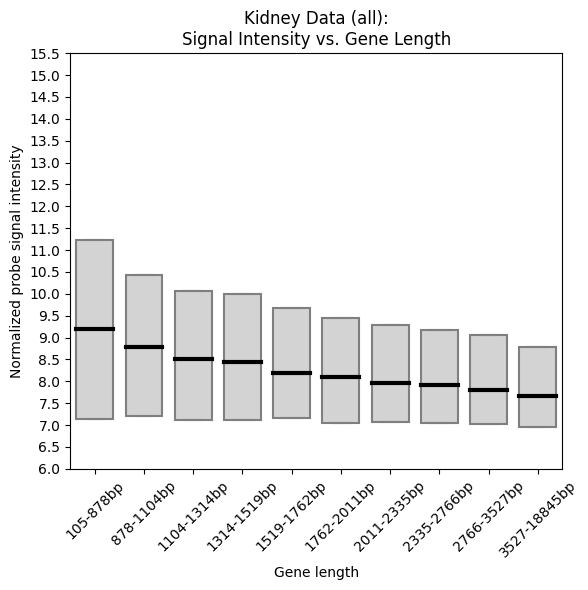

In [12]:
plt.figure(figsize=(6,6))

ax = sns.boxplot(data=kidney_merged, x="BinnedLength", y="MeanIntensity", 
                 showfliers=False, whis=0,
                 width=0.75, 
                 color='lightgray', 
                 medianprops=dict(color='black', linewidth=3))

plt.xticks(ticks=range(len(bin_labels)), labels=bin_labels, rotation=45)
y_min = np.floor(2 * min(kidney_merged['MeanIntensity'])) / 2
y_max = np.ceil(2 * max(kidney_merged['MeanIntensity'])) / 2
yticks = np.arange(y_min, y_max + 0.5, 0.5)
plt.yticks(ticks=yticks)
plt.xlabel("Gene length")
plt.ylabel("Normalized probe signal intensity")
plt.title("Kidney Data (all):\nSignal Intensity vs. Gene Length")
plt.tight_layout()
plt.show()

#plt.savefig('mouse_kidney_control.png', dpi=300, bbox_inches='tight')

In [13]:
total_counts = kidney_merged[['kidney_normal_batch1_rep1', 'kidney_normal_batch1_rep2', 'kidney_normal_batch2']].sum(axis=1)
cpm = (total_counts / total_counts.sum()) * 1e6
kidney_merged['cpm'] = pd.DataFrame(cpm)

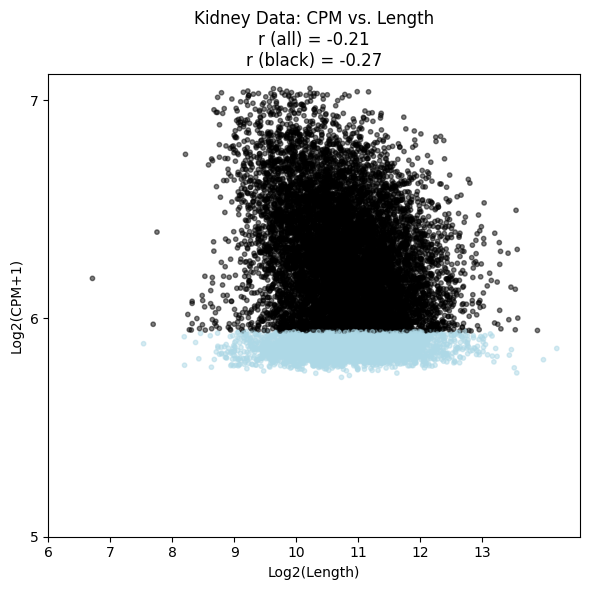

In [14]:
fig, ax = plt.subplots(figsize=(6, 6))

x_data = np.log2(kidney_merged['Length'])
y_data = np.log2(kidney_merged['cpm'] + 1)

colors = ['black' if c > np.percentile(cpm,25) else 'lightblue' for c in cpm]
#'lightblue' if val <= np.percentile(cpm, 25) else 'black' for val in cpm]

ax.scatter(x_data, y_data, color=colors, alpha=0.5, s=10)
ax.set_xlabel('Log2(Length)')
ax.set_ylabel('Log2(CPM+1)')

ax.set_xticks(np.arange(int(min(x_data)), int(max(x_data))))
ax.set_yticks(np.arange(int(min(y_data)), int(max(y_data)) + 1))

# Compute Pearson's coefficient for all
r_cpm_all, _ = pearsonr(x_data, y_data)

# For subset
x_data_black = [x for x, val in zip(x_data, cpm) if val > np.percentile(cpm, 25)]
y_data_black = [y for y, val in zip(y_data, cpm) if val > np.percentile(cpm, 25)]

r_cpm_black, _ = pearsonr(x_data_black, y_data_black)

ax.set_title(f'Kidney Data: CPM vs. Length\nr (all) = {r_cpm_all:.2f}\nr (black) = {r_cpm_black:.2f}')

plt.tight_layout()
plt.show()

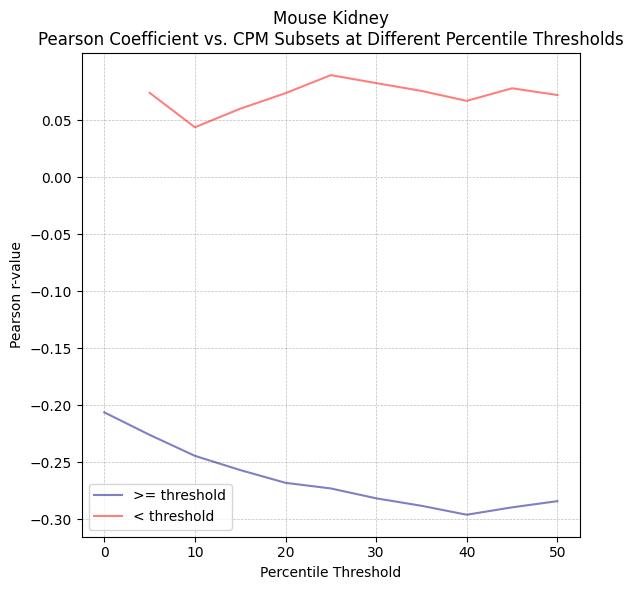

In [15]:
x_data = np.log2(kidney_merged['Length'])
y_data = np.log2(kidney_merged['cpm'] + 1)

# Initialize lists to store r-values
r_values_above_threshold = []
r_values_below_threshold = []

# Define percentile thresholds instead of fixed CPM thresholds
percentile_thresholds = np.arange(0, 51, 5)  # Thresholds from 0th to 50th percentile, in steps of 5%

for percentile in percentile_thresholds:
    threshold = np.percentile(y_data, percentile)

    # Data above the percentile threshold
    x_data_above = x_data[y_data >= threshold]
    y_data_above = y_data[y_data >= threshold]

    # Pearson's coefficient for the subset above the threshold
    if len(x_data_above) > 0 and len(y_data_above) > 0:
        r_value_above, _ = pearsonr(x_data_above, y_data_above)
    else:
        r_value_above = np.nan

    r_values_above_threshold.append(r_value_above)
    
    # Data below the percentile threshold
    x_data_below = x_data[y_data < threshold]
    y_data_below = y_data[y_data < threshold]

    # Pearson's coefficient for the subset below the threshold
    if len(x_data_below) > 0 and len(y_data_below) > 0:
        r_value_below, _ = pearsonr(x_data_below, y_data_below)
    else:
        r_value_below = np.nan

    r_values_below_threshold.append(r_value_below)

# Plot
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(percentile_thresholds, r_values_above_threshold, color='darkblue', alpha=0.5, label='>= threshold')
ax.plot(percentile_thresholds, r_values_below_threshold, color='red', alpha=0.5, label='< threshold')

ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
ax.set_xlabel('Percentile Threshold')
ax.set_ylabel('Pearson r-value')

all_r_values = r_values_above_threshold + r_values_below_threshold
ax.set_yticks(np.arange(np.floor(np.nanmin(all_r_values) * 10) / 10,
                        np.ceil(np.nanmax(all_r_values) * 10) / 10,
                        step=0.05))
ax.set_title('Mouse Kidney\nPearson Coefficient vs. CPM Subsets at Different Percentile Thresholds')
ax.legend()
plt.tight_layout()
plt.show()

### Mouse liver

In [16]:
liver_merged = pd.merge(liver_data, merged, left_on=['Symbol'], right_on=['gene_symbol'], how='inner')
liver_merged["Length"] = liver_merged["Length"].astype(float)
liver_merged["MeanIntensity"] = liver_merged[["liver_normal_batch2_rep1", "liver_normal_batch2_rep2", "liver_normal_batch3_rep1", "liver_normal_batch3_rep2"]].mean(axis=1)

In [17]:
liver_merged.dropna(subset=["Length"], inplace=True)
bins, bin_edges = pd.qcut(liver_merged["Length"], n_bins, labels=False, retbins=True)

bin_labels = []
for i in range(len(bin_edges)-1):
    bin_label = f"{round(bin_edges[i])}-{round(bin_edges[i+1])}bp"
    bin_labels.append(bin_label)
    print(f"Bin {i}: {bin_label}")

liver_merged["BinnedLength"] = bins

Bin 0: 105-878bp
Bin 1: 878-1104bp
Bin 2: 1104-1314bp
Bin 3: 1314-1519bp
Bin 4: 1519-1762bp
Bin 5: 1762-2011bp
Bin 6: 2011-2335bp
Bin 7: 2335-2766bp
Bin 8: 2766-3527bp
Bin 9: 3527-18845bp


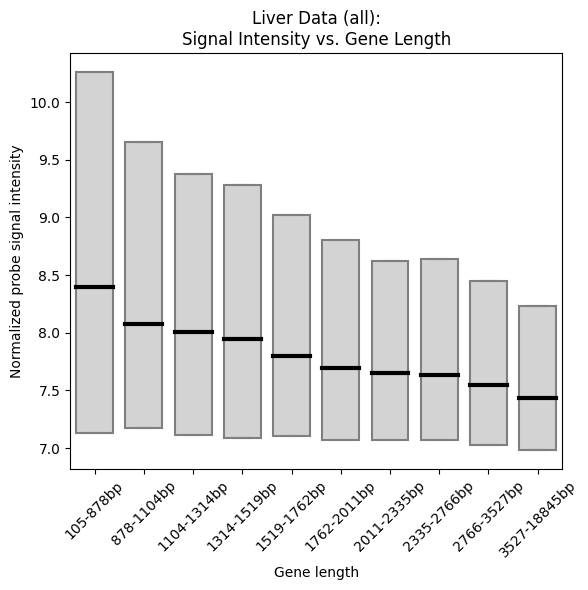

In [18]:
plt.figure(figsize=(6,6))

ax = sns.boxplot(data=liver_merged, x="BinnedLength", y="MeanIntensity", 
                 showfliers=False, whis=0,
                 width=0.75, 
                 color='lightgray', 
                 medianprops=dict(color='black', linewidth=3))

plt.xticks(ticks=range(len(bin_labels)), labels=bin_labels, rotation=45)
y_min = np.floor(2 * min(kidney_merged['MeanIntensity'])) / 2
y_max = np.ceil(2 * max(kidney_merged['MeanIntensity'])) / 2
yticks = np.arange(y_min, y_max + 0.5, 0.5)
plt.xlabel("Gene length")
plt.ylabel("Normalized probe signal intensity")
plt.title("Liver Data (all):\nSignal Intensity vs. Gene Length")
plt.tight_layout() 
plt.show()

#plt.savefig('mouse_liver_control.png', dpi=300, bbox_inches='tight')

In [19]:
total_counts = liver_merged[["liver_normal_batch2_rep1", "liver_normal_batch2_rep2", "liver_normal_batch3_rep1", "liver_normal_batch3_rep2"]].sum(axis=1)
cpm = (total_counts / total_counts.sum()) * 1e6
liver_merged['cpm'] = pd.DataFrame(cpm)

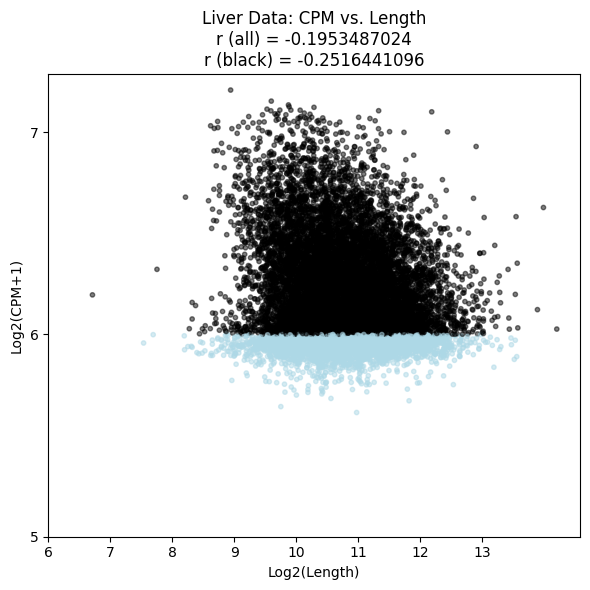

In [20]:
fig, ax = plt.subplots(figsize=(6, 6))

x_data = np.log2(liver_merged['Length'])
y_data = np.log2(liver_merged['cpm'] + 1)

colors = ['lightblue' if val <= np.percentile(cpm, 25) else 'black' for val in cpm]

ax.scatter(x_data, y_data, color=colors, alpha=0.5, s=10)
ax.set_xlabel('Log2(Length)')
ax.set_ylabel('Log2(CPM+1)')

ax.set_xticks(np.arange(int(min(x_data)), int(max(x_data))))
ax.set_yticks(np.arange(int(min(y_data)), int(max(y_data)) + 1))

# Compute Pearson's coefficient for all
r_cpm_all, _ = pearsonr(x_data, y_data)

# For subset
x_data_black = [x for x, val in zip(x_data, cpm) if val > np.percentile(cpm, 25)]
y_data_black = [y for y, val in zip(y_data, cpm) if val > np.percentile(cpm, 25)]

r_cpm_black, _ = pearsonr(x_data_black, y_data_black)

ax.set_title(f'Liver Data: CPM vs. Length\nr (all) = {r_cpm_all:.10f}\nr (black) = {r_cpm_black:.10f}')

plt.tight_layout()
plt.show()

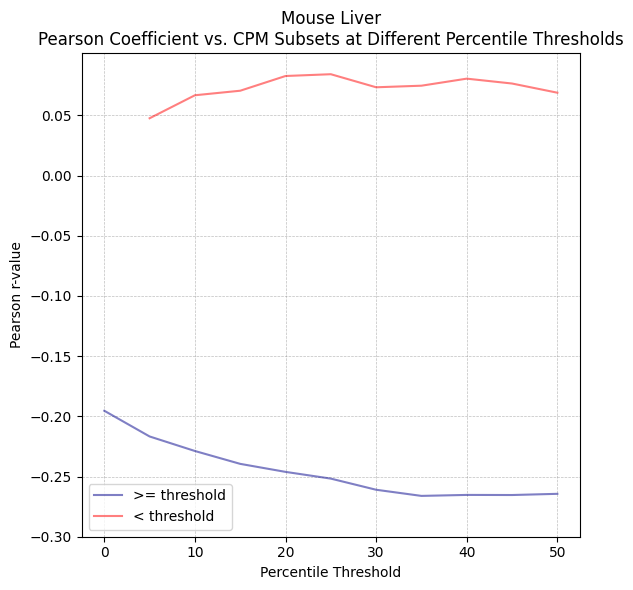

In [21]:
x_data = np.log2(liver_merged['Length'])
y_data = np.log2(liver_merged['cpm'] + 1)

# Initialize lists to store r-values
r_values_above_threshold = []
r_values_below_threshold = []

# Define percentile thresholds instead of fixed CPM thresholds
percentile_thresholds = np.arange(0, 51, 5)  # Thresholds from 0th to 50th percentile, in steps of 5%

for percentile in percentile_thresholds:
    threshold = np.percentile(y_data, percentile)

    # Data above the percentile threshold
    x_data_above = x_data[y_data >= threshold]
    y_data_above = y_data[y_data >= threshold]

    # Pearson's coefficient for the subset above the threshold
    if len(x_data_above) > 0 and len(y_data_above) > 0:
        r_value_above, _ = pearsonr(x_data_above, y_data_above)
    else:
        r_value_above = np.nan

    r_values_above_threshold.append(r_value_above)
    
    # Data below the percentile threshold
    x_data_below = x_data[y_data < threshold]
    y_data_below = y_data[y_data < threshold]

    # Pearson's coefficient for the subset below the threshold
    if len(x_data_below) > 0 and len(y_data_below) > 0:
        r_value_below, _ = pearsonr(x_data_below, y_data_below)
    else:
        r_value_below = np.nan

    r_values_below_threshold.append(r_value_below)

# Plot
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(percentile_thresholds, r_values_above_threshold, color='darkblue', alpha=0.5, label='>= threshold')
ax.plot(percentile_thresholds, r_values_below_threshold, color='red', alpha=0.5, label='< threshold')

ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
ax.set_xlabel('Percentile Threshold')
ax.set_ylabel('Pearson r-value')

all_r_values = r_values_above_threshold + r_values_below_threshold
ax.set_yticks(np.arange(np.floor(np.nanmin(all_r_values) * 10) / 10,
                        np.ceil(np.nanmax(all_r_values) * 10) / 10,
                        step=0.05))
ax.set_title('Mouse Liver\nPearson Coefficient vs. CPM Subsets at Different Percentile Thresholds')
ax.legend()
plt.tight_layout()
plt.show()

### Mouse lung

In [22]:
lung_merged = pd.merge(lung_data, merged, left_on=['Symbol'], right_on=['gene_symbol'], how='inner')
lung_merged["Length"] = lung_merged["Length"].astype(float)
lung_merged["MeanIntensity"] = lung_merged[["lung_normal_rep1", "lung_normal_rep2"]].mean(axis=1)

In [23]:
lung_merged.dropna(subset=["Length"], inplace=True)
bins, bin_edges = pd.qcut(lung_merged["Length"], n_bins, labels=False, retbins=True)

bin_labels = []
for i in range(len(bin_edges)-1):
    bin_label = f"{round(bin_edges[i])}-{round(bin_edges[i+1])}bp"
    bin_labels.append(bin_label)
    print(f"Bin {i}: {bin_label}")

lung_merged["BinnedLength"] = bins

Bin 0: 105-875bp
Bin 1: 875-1094bp
Bin 2: 1094-1297bp
Bin 3: 1297-1491bp
Bin 4: 1491-1722bp
Bin 5: 1722-1967bp
Bin 6: 1967-2267bp
Bin 7: 2267-2688bp
Bin 8: 2688-3406bp
Bin 9: 3406-18845bp


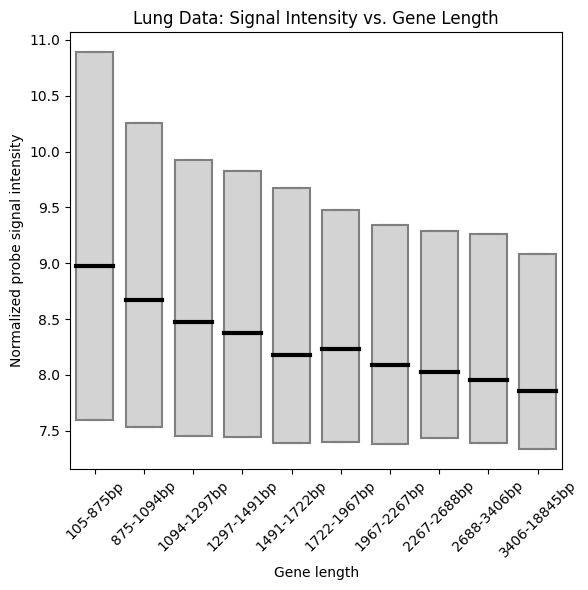

In [24]:
plt.figure(figsize=(6,6))

ax = sns.boxplot(data=lung_merged, x="BinnedLength", y="MeanIntensity", 
                 showfliers=False, whis=0,
                 width=0.75, 
                 color='lightgray', 
                 medianprops=dict(color='black', linewidth=3))

plt.xticks(ticks=range(len(bin_labels)), labels=bin_labels, rotation=45)
y_min = np.floor(2 * min(kidney_merged['MeanIntensity'])) / 2
y_max = np.ceil(2 * max(kidney_merged['MeanIntensity'])) / 2
yticks = np.arange(y_min, y_max + 0.5, 0.5)
plt.xlabel("Gene length")
plt.ylabel("Normalized probe signal intensity")
plt.title("Lung Data: Signal Intensity vs. Gene Length")
plt.tight_layout()
plt.show()

#plt.savefig('mouse_lung_control.png', dpi=300, bbox_inches='tight')

In [25]:
total_counts = lung_merged[["lung_normal_rep1", "lung_normal_rep2"]].sum(axis=1)
cpm = (total_counts / total_counts.sum()) * 1e6
lung_merged['cpm'] = pd.DataFrame(cpm)

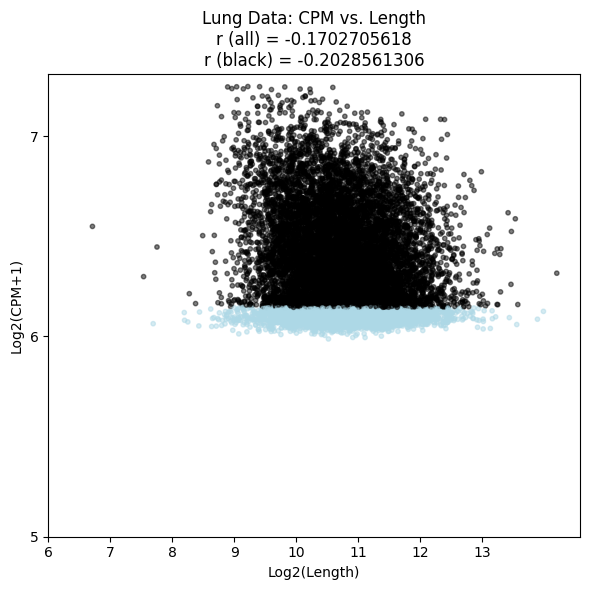

In [26]:
fig, ax = plt.subplots(figsize=(6, 6))

x_data = np.log2(lung_merged['Length'])
y_data = np.log2(lung_merged['cpm'] + 1)

colors = ['lightblue' if val <= np.percentile(cpm, 25) else 'black' for val in cpm]

ax.scatter(x_data, y_data, color=colors, alpha=0.5, s=10)
ax.set_xlabel('Log2(Length)')
ax.set_ylabel('Log2(CPM+1)')

ax.set_xticks(np.arange(int(min(x_data)), int(max(x_data))))
ax.set_yticks(np.arange(int(min(y_data)), int(max(y_data)) + 1))

# Compute Pearson's coefficient for all
r_cpm_all, _ = pearsonr(x_data, y_data)

# For subset
x_data_black = [x for x, val in zip(x_data, cpm) if val > np.percentile(cpm, 25)]
y_data_black = [y for y, val in zip(y_data, cpm) if val > np.percentile(cpm, 25)]

r_cpm_black, _ = pearsonr(x_data_black, y_data_black)

ax.set_title(f'Lung Data: CPM vs. Length\nr (all) = {r_cpm_all:.10f}\nr (black) = {r_cpm_black:.10f}')

plt.tight_layout()
plt.show()

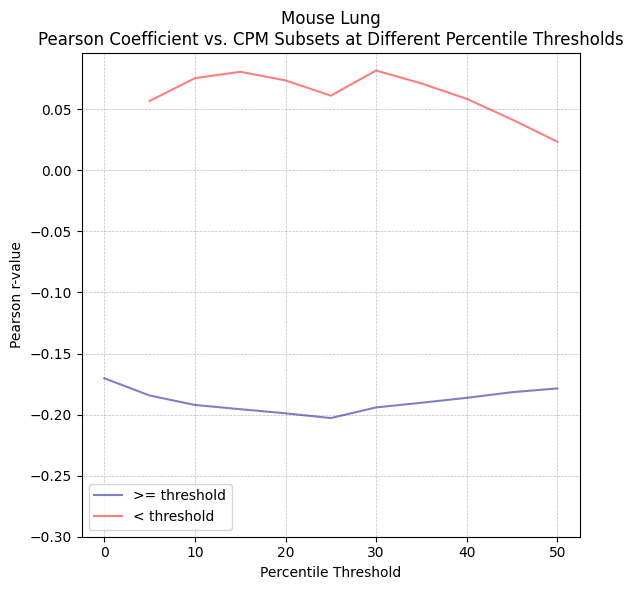

In [27]:
x_data = np.log2(lung_merged['Length'])
y_data = np.log2(lung_merged['cpm'] + 1)

# Initialize lists to store r-values
r_values_above_threshold = []
r_values_below_threshold = []

# Define percentile thresholds instead of fixed CPM thresholds
percentile_thresholds = np.arange(0, 51, 5)  # Thresholds from 0th to 50th percentile, in steps of 5%

for percentile in percentile_thresholds:
    threshold = np.percentile(y_data, percentile)

    # Data above the percentile threshold
    x_data_above = x_data[y_data >= threshold]
    y_data_above = y_data[y_data >= threshold]

    # Pearson's coefficient for the subset above the threshold
    if len(x_data_above) > 0 and len(y_data_above) > 0:
        r_value_above, _ = pearsonr(x_data_above, y_data_above)
    else:
        r_value_above = np.nan

    r_values_above_threshold.append(r_value_above)
    
    # Data below the percentile threshold
    x_data_below = x_data[y_data < threshold]
    y_data_below = y_data[y_data < threshold]

    # Pearson's coefficient for the subset below the threshold
    if len(x_data_below) > 0 and len(y_data_below) > 0:
        r_value_below, _ = pearsonr(x_data_below, y_data_below)
    else:
        r_value_below = np.nan

    r_values_below_threshold.append(r_value_below)

# Plot
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(percentile_thresholds, r_values_above_threshold, color='darkblue', alpha=0.5, label='>= threshold')
ax.plot(percentile_thresholds, r_values_below_threshold, color='red', alpha=0.5, label='< threshold')

ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
ax.set_xlabel('Percentile Threshold')
ax.set_ylabel('Pearson r-value')

all_r_values = r_values_above_threshold + r_values_below_threshold
ax.set_yticks(np.arange(np.floor(np.nanmin(all_r_values) * 10) / 10,
                        np.ceil(np.nanmax(all_r_values) * 10) / 10,
                        step=0.05))
ax.set_title('Mouse Lung\nPearson Coefficient vs. CPM Subsets at Different Percentile Thresholds')
ax.legend()
plt.tight_layout()
plt.show()

## Human microarrays

Load and inspect the data

In [30]:
human_esc = pd.read_csv(dir+"human_embryonic_stem_cells.csv")
human_pbmc = pd.read_csv(dir+"human_pbmc.csv")
human_brain = pd.read_csv(dir+"human_brain.csv")
gene_lengths =  pd.read_csv('human_gene_lengths_exons.txt', sep='\t', names=['ID', 'Length'])

In [31]:
human_brain = human_brain.groupby('gene').mean().reset_index() # collapse by averaging signal intensity values where genes are the same

In [32]:
mapping = pd.read_csv("human_t2g_nac.txt", sep='\t', names=['transcript_ID', 'gene_ID', 'gene_symbol', 'transcript_name', 'chr', 'transcript_start', 'transcript_end', 'strand'], low_memory=False)
mapping = mapping.drop(columns=['transcript_ID', 'transcript_name', 'chr', 'transcript_start', 'transcript_end', 'strand'])
mapping = mapping.drop_duplicates()

In [33]:
gene_lengths['ID'] = gene_lengths['ID'] #.str.split(".").str[0]

In [34]:
merged = pd.merge(mapping, gene_lengths, left_on='gene_ID', right_on='ID', how='inner')

### Human brain

In [35]:
brain_merged = pd.merge(human_brain, merged, left_on=['gene'], right_on=['gene_symbol'], how='inner')
brain_merged["Length"] = brain_merged["Length"].astype(float)
brain_merged["MeanIntensity"] = brain_merged[["dentate_nucleus_left", "fastigial_nucleus_left", "emboliform_nucleus_right"]].mean(axis=1)

In [36]:
brain_merged.dropna(subset=["Length"], inplace=True)
bins, bin_edges = pd.qcut(brain_merged["Length"], n_bins, labels=False, retbins=True)

bin_labels = []
for i in range(len(bin_edges)-1):
    bin_label = f"{round(bin_edges[i])}-{round(bin_edges[i+1])}bp"
    bin_labels.append(bin_label)
    print(f"Bin {i}: {bin_label}")

brain_merged["BinnedLength"] = bins

Bin 0: 192-907bp
Bin 1: 907-1098bp
Bin 2: 1098-1284bp
Bin 3: 1284-1486bp
Bin 4: 1486-1707bp
Bin 5: 1707-1971bp
Bin 6: 1971-2315bp
Bin 7: 2315-2821bp
Bin 8: 2821-3711bp
Bin 9: 3711-36798bp


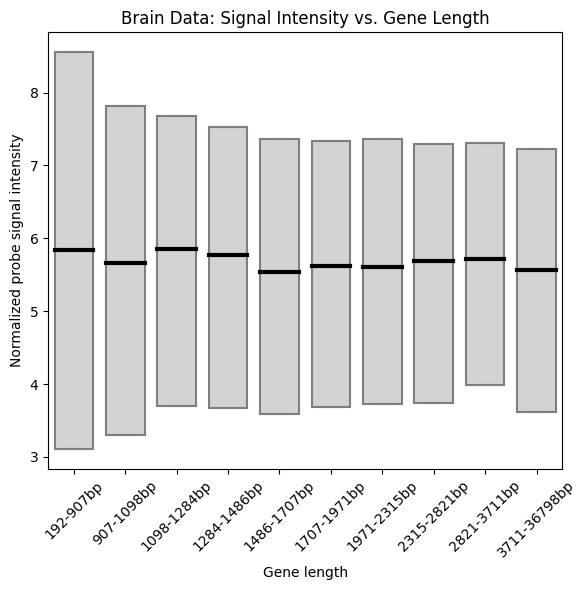

In [37]:
plt.figure(figsize=(6,6))

ax = sns.boxplot(data=brain_merged, x="BinnedLength", y="MeanIntensity", 
                 showfliers=False, whis=0,
                 width=0.75, 
                 color='lightgray', 
                 medianprops=dict(color='black', linewidth=3))

plt.xticks(ticks=range(len(bin_labels)), labels=bin_labels, rotation=45)
y_min = np.floor(2 * min(kidney_merged['MeanIntensity'])) / 2
y_max = np.ceil(2 * max(kidney_merged['MeanIntensity'])) / 2
yticks = np.arange(y_min, y_max + 0.5, 0.5)
plt.xlabel("Gene length")
plt.ylabel("Normalized probe signal intensity")
plt.title("Brain Data: Signal Intensity vs. Gene Length")
plt.tight_layout()
plt.show()

#plt.savefig('human_brain.png', dpi=300, bbox_inches='tight')

In [38]:
total_counts = brain_merged[["dentate_nucleus_left", "fastigial_nucleus_left", "emboliform_nucleus_right"]].sum(axis=1)
cpm = (total_counts / total_counts.sum()) * 1e6
brain_merged['cpm'] = pd.DataFrame(cpm)

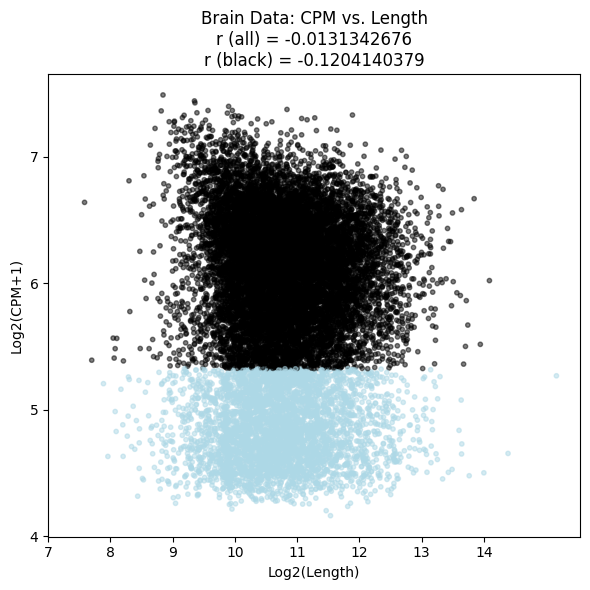

In [39]:
fig, ax = plt.subplots(figsize=(6, 6))

x_data = np.log2(brain_merged['Length'])
y_data = np.log2(brain_merged['cpm'] + 1)

colors = ['lightblue' if val <= np.percentile(cpm, 25) else 'black' for val in cpm]

ax.scatter(x_data, y_data, color=colors, alpha=0.5, s=10)
ax.set_xlabel('Log2(Length)')
ax.set_ylabel('Log2(CPM+1)')

ax.set_xticks(np.arange(int(min(x_data)), int(max(x_data))))
ax.set_yticks(np.arange(int(min(y_data)), int(max(y_data)) + 1))

# Compute Pearson's coefficient for all
r_cpm_all, _ = pearsonr(x_data, y_data)

# For subset
x_data_black = [x for x, val in zip(x_data, cpm) if val > np.percentile(cpm, 25)]
y_data_black = [y for y, val in zip(y_data, cpm) if val > np.percentile(cpm, 25)]

r_cpm_black, _ = pearsonr(x_data_black, y_data_black)

ax.set_title(f'Brain Data: CPM vs. Length\nr (all) = {r_cpm_all:.10f}\nr (black) = {r_cpm_black:.10f}')

plt.tight_layout()
plt.show()

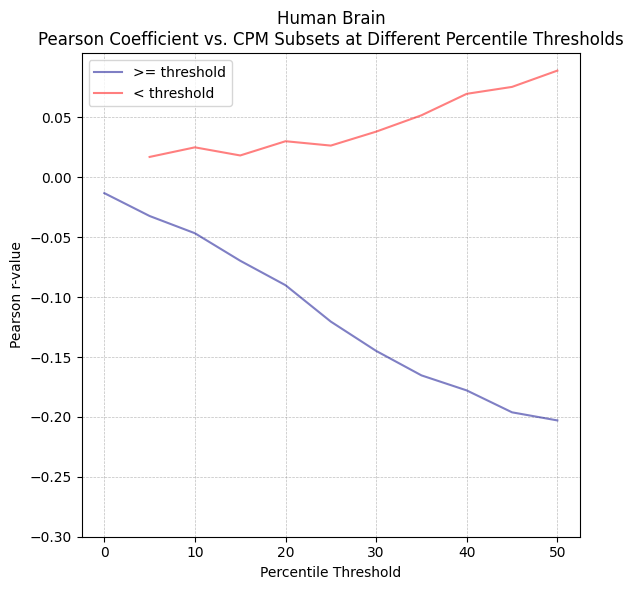

In [40]:
x_data = np.log2(brain_merged['Length'])
y_data = np.log2(brain_merged['cpm'] + 1)

# Initialize lists to store r-values
r_values_above_threshold = []
r_values_below_threshold = []

# Define percentile thresholds instead of fixed CPM thresholds
percentile_thresholds = np.arange(0, 51, 5)  # Thresholds from 0th to 50th percentile, in steps of 5%

for percentile in percentile_thresholds:
    threshold = np.percentile(y_data, percentile)

    # Data above the percentile threshold
    x_data_above = x_data[y_data >= threshold]
    y_data_above = y_data[y_data >= threshold]

    # Pearson's coefficient for the subset above the threshold
    if len(x_data_above) > 0 and len(y_data_above) > 0:
        r_value_above, _ = pearsonr(x_data_above, y_data_above)
    else:
        r_value_above = np.nan

    r_values_above_threshold.append(r_value_above)
    
    # Data below the percentile threshold
    x_data_below = x_data[y_data < threshold]
    y_data_below = y_data[y_data < threshold]

    # Pearson's coefficient for the subset below the threshold
    if len(x_data_below) > 0 and len(y_data_below) > 0:
        r_value_below, _ = pearsonr(x_data_below, y_data_below)
    else:
        r_value_below = np.nan

    r_values_below_threshold.append(r_value_below)

# Plot
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(percentile_thresholds, r_values_above_threshold, color='darkblue', alpha=0.5, label='>= threshold')
ax.plot(percentile_thresholds, r_values_below_threshold, color='red', alpha=0.5, label='< threshold')

ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
ax.set_xlabel('Percentile Threshold')
ax.set_ylabel('Pearson r-value')

all_r_values = r_values_above_threshold + r_values_below_threshold
ax.set_yticks(np.arange(np.floor(np.nanmin(all_r_values) * 10) / 10,
                        np.ceil(np.nanmax(all_r_values) * 10) / 10,
                        step=0.05))
ax.set_title('Human Brain\nPearson Coefficient vs. CPM Subsets at Different Percentile Thresholds')
ax.legend()
plt.tight_layout()
plt.show()

### Human ESC

In [41]:
data_columns = human_esc.columns[1:]

Apply log2 transformation

In [45]:
ratio = human_esc[data_columns].median().mean()
human_esc = log2_transform_ratios(human_esc, ratio)

In [46]:
esc_merged = pd.merge(human_esc, merged, left_on=['ID_REF'], right_on=['gene_symbol'], how='inner')
esc_merged["Length"] = esc_merged["Length"].astype(float)
esc_merged["MeanIntensity"] = esc_merged[["GSM1589812", "GSM1589813", "GSM1589814"]].mean(axis=1)

In [47]:
esc_merged.dropna(subset=["Length"], inplace=True)
bins, bin_edges = pd.qcut(esc_merged["Length"], n_bins, labels=False, retbins=True)

bin_labels = []
for i in range(len(bin_edges)-1):
    bin_label = f"{round(bin_edges[i])}-{round(bin_edges[i+1])}bp"
    bin_labels.append(bin_label)
    print(f"Bin {i}: {bin_label}")

esc_merged["BinnedLength"] = bins

Bin 0: 117-906bp
Bin 1: 906-1098bp
Bin 2: 1098-1286bp
Bin 3: 1286-1491bp
Bin 4: 1491-1712bp
Bin 5: 1712-1973bp
Bin 6: 1973-2318bp
Bin 7: 2318-2833bp
Bin 8: 2833-3719bp
Bin 9: 3719-36798bp


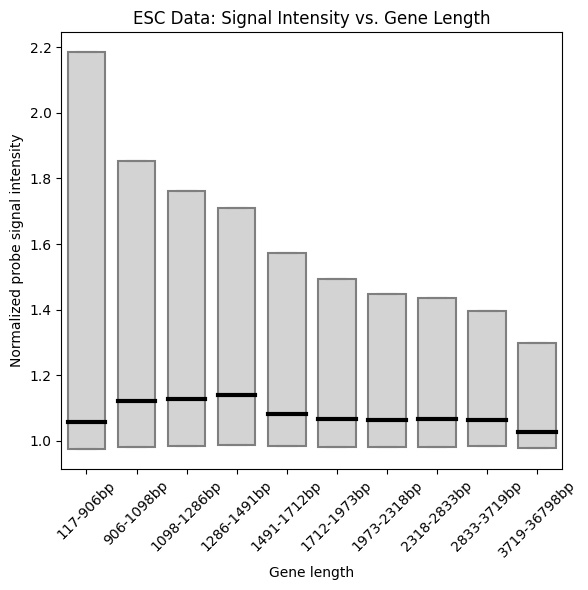

In [48]:
plt.figure(figsize=(6,6))

ax = sns.boxplot(data=esc_merged, x="BinnedLength", y="MeanIntensity", 
                 showfliers=False, whis=0,
                 width=0.75, 
                 color='lightgray', 
                 medianprops=dict(color='black', linewidth=3))

plt.xticks(ticks=range(len(bin_labels)), labels=bin_labels, rotation=45)
y_min = np.floor(2 * min(kidney_merged['MeanIntensity'])) / 2
y_max = np.ceil(2 * max(kidney_merged['MeanIntensity'])) / 2
yticks = np.arange(y_min, y_max + 0.5, 0.5)
plt.xlabel("Gene length")
plt.ylabel("Normalized probe signal intensity")
plt.title("ESC Data: Signal Intensity vs. Gene Length")
plt.tight_layout()
plt.show()

#plt.savefig('human_esc.png', dpi=300, bbox_inches='tight')

In [49]:
total_counts = esc_merged[["GSM1589812", "GSM1589813", "GSM1589814"]].sum(axis=1)
cpm = (total_counts / total_counts.sum()) * 1e6
esc_merged['cpm'] = pd.DataFrame(cpm)

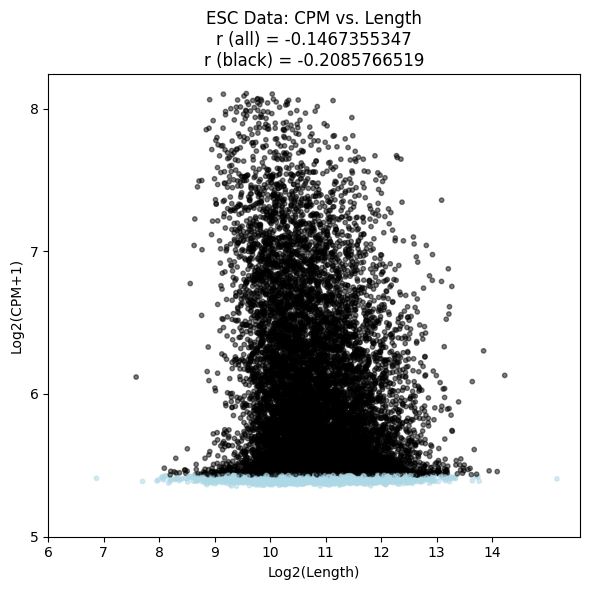

In [50]:
fig, ax = plt.subplots(figsize=(6, 6))

x_data = np.log2(esc_merged['Length'])
y_data = np.log2(esc_merged['cpm'] + 1)

colors = ['lightblue' if val <= np.percentile(cpm, 25) else 'black' for val in cpm]

ax.scatter(x_data, y_data, color=colors, alpha=0.5, s=10)
ax.set_xlabel('Log2(Length)')
ax.set_ylabel('Log2(CPM+1)')

ax.set_xticks(np.arange(int(min(x_data)), int(max(x_data))))
ax.set_yticks(np.arange(int(min(y_data)), int(max(y_data)) + 1))

# Compute Pearson's coefficient for all
r_cpm_all, _ = pearsonr(x_data, y_data)

# For subset
x_data_black = [x for x, val in zip(x_data, cpm) if val > np.percentile(cpm, 25)]
y_data_black = [y for y, val in zip(y_data, cpm) if val > np.percentile(cpm, 25)]

r_cpm_black, _ = pearsonr(x_data_black, y_data_black)

ax.set_title(f'ESC Data: CPM vs. Length\nr (all) = {r_cpm_all:.10f}\nr (black) = {r_cpm_black:.10f}')

plt.tight_layout()
plt.show()

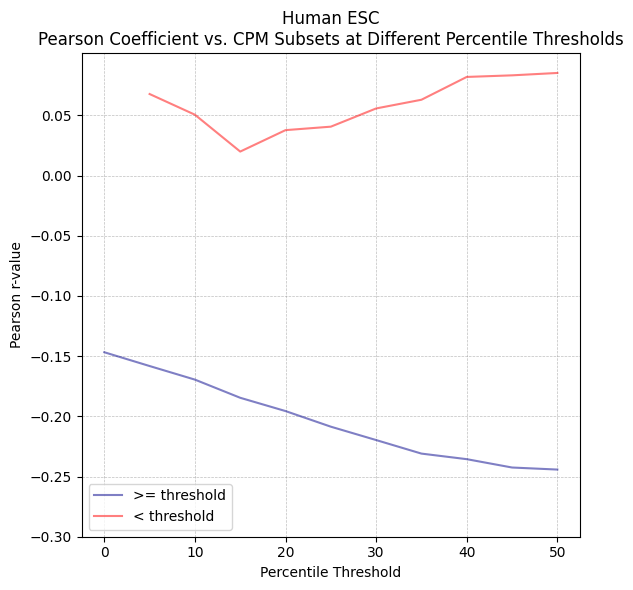

In [51]:
x_data = np.log2(esc_merged['Length'])
y_data = np.log2(esc_merged['cpm'] + 1)

# Initialize lists to store r-values
r_values_above_threshold = []
r_values_below_threshold = []

# Define percentile thresholds instead of fixed CPM thresholds
percentile_thresholds = np.arange(0, 51, 5)  # Thresholds from 0th to 50th percentile, in steps of 5%

for percentile in percentile_thresholds:
    threshold = np.percentile(y_data, percentile)

    # Data above the percentile threshold
    x_data_above = x_data[y_data >= threshold]
    y_data_above = y_data[y_data >= threshold]

    # Pearson's coefficient for the subset above the threshold
    if len(x_data_above) > 0 and len(y_data_above) > 0:
        r_value_above, _ = pearsonr(x_data_above, y_data_above)
    else:
        r_value_above = np.nan

    r_values_above_threshold.append(r_value_above)
    
    # Data below the percentile threshold
    x_data_below = x_data[y_data < threshold]
    y_data_below = y_data[y_data < threshold]

    # Pearson's coefficient for the subset below the threshold
    if len(x_data_below) > 0 and len(y_data_below) > 0:
        r_value_below, _ = pearsonr(x_data_below, y_data_below)
    else:
        r_value_below = np.nan

    r_values_below_threshold.append(r_value_below)

# Plot
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(percentile_thresholds, r_values_above_threshold, color='darkblue', alpha=0.5, label='>= threshold')
ax.plot(percentile_thresholds, r_values_below_threshold, color='red', alpha=0.5, label='< threshold')

ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
ax.set_xlabel('Percentile Threshold')
ax.set_ylabel('Pearson r-value')

all_r_values = r_values_above_threshold + r_values_below_threshold
ax.set_yticks(np.arange(np.floor(np.nanmin(all_r_values) * 10) / 10,
                        np.ceil(np.nanmax(all_r_values) * 10) / 10,
                        step=0.05))
ax.set_title('Human ESC\nPearson Coefficient vs. CPM Subsets at Different Percentile Thresholds')
ax.legend()
plt.tight_layout()
plt.show()

### Human PBMC

In [52]:
data_columns = human_pbmc.columns[1:]

Apply log2 transformation

In [53]:
ratio = human_pbmc[data_columns].median().mean()
human_pbmc = log2_transform_ratios(human_pbmc, ratio)

In [54]:
pbmc_merged = pd.merge(human_pbmc, merged, left_on=['ID_REF'], right_on=['gene_symbol'], how='inner')
pbmc_merged["Length"] = pbmc_merged["Length"].astype(float)
pbmc_merged["MeanIntensity"] = pbmc_merged[["GSM2090239", "GSM2090240", "GSM2090241"]].mean(axis=1)

In [55]:
pbmc_merged.dropna(subset=["Length"], inplace=True)
bins, bin_edges = pd.qcut(pbmc_merged["Length"], n_bins, labels=False, retbins=True)

bin_labels = []
for i in range(len(bin_edges)-1):
    bin_label = f"{round(bin_edges[i])}-{round(bin_edges[i+1])}bp"
    bin_labels.append(bin_label)
    print(f"Bin {i}: {bin_label}")

pbmc_merged["BinnedLength"] = bins

Bin 0: 117-905bp
Bin 1: 905-1096bp
Bin 2: 1096-1285bp
Bin 3: 1285-1491bp
Bin 4: 1491-1711bp
Bin 5: 1711-1972bp
Bin 6: 1972-2316bp
Bin 7: 2316-2831bp
Bin 8: 2831-3719bp
Bin 9: 3719-36798bp


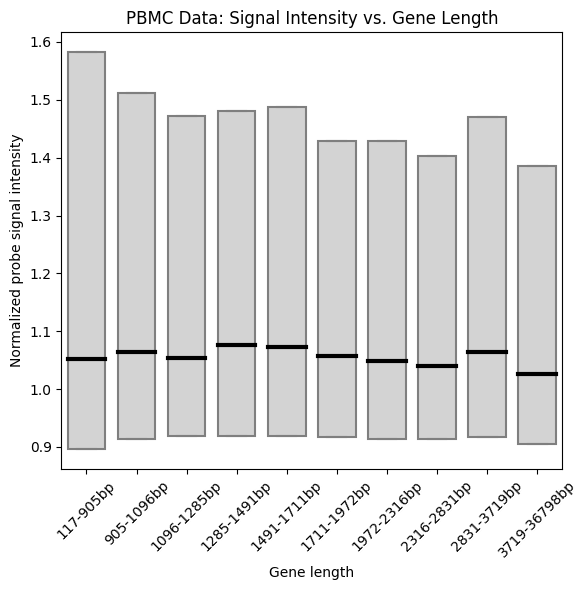

In [56]:
plt.figure(figsize=(6,6))

ax = sns.boxplot(data=pbmc_merged, x="BinnedLength", y="MeanIntensity", 
                 showfliers=False, whis=0,
                 width=0.75, 
                 color='lightgray', 
                 medianprops=dict(color='black', linewidth=3))

plt.xticks(ticks=range(len(bin_labels)), labels=bin_labels, rotation=45)
y_min = np.floor(2 * min(kidney_merged['MeanIntensity'])) / 2
y_max = np.ceil(2 * max(kidney_merged['MeanIntensity'])) / 2
yticks = np.arange(y_min, y_max + 0.5, 0.5)
plt.xlabel("Gene length")
plt.ylabel("Normalized probe signal intensity")
plt.title("PBMC Data: Signal Intensity vs. Gene Length")
plt.tight_layout()
plt.show()

#plt.savefig('human_pbmc.png', dpi=300, bbox_inches='tight')

In [57]:
total_counts = pbmc_merged[["GSM2090239", "GSM2090240", "GSM2090241"]].sum(axis=1)
cpm = (total_counts / total_counts.sum()) * 1e6
pbmc_merged['cpm'] = pd.DataFrame(cpm)

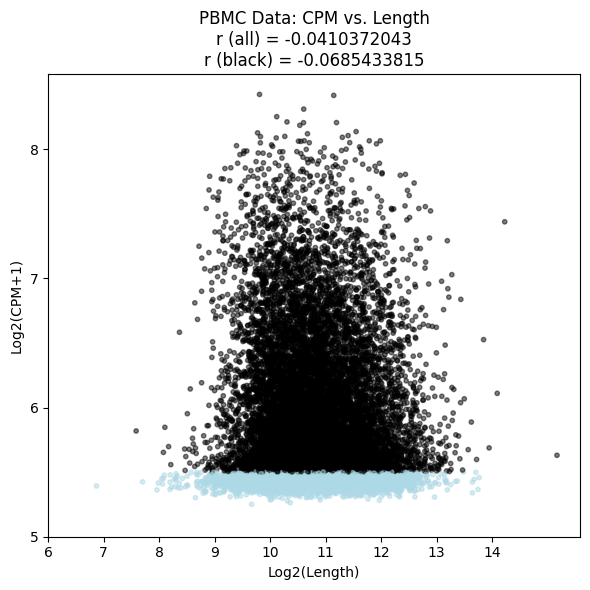

In [58]:
fig, ax = plt.subplots(figsize=(6, 6))

x_data = np.log2(pbmc_merged['Length'])
y_data = np.log2(pbmc_merged['cpm'] + 1)

colors = ['lightblue' if val <= np.percentile(cpm, 25) else 'black' for val in cpm]

ax.scatter(x_data, y_data, color=colors, alpha=0.5, s=10)
ax.set_xlabel('Log2(Length)')
ax.set_ylabel('Log2(CPM+1)')

ax.set_xticks(np.arange(int(min(x_data)), int(max(x_data))))
ax.set_yticks(np.arange(int(min(y_data)), int(max(y_data)) + 1))

# Compute Pearson's coefficient for all
r_cpm_all, _ = pearsonr(x_data, y_data)

# For subset
x_data_black = [x for x, val in zip(x_data, cpm) if val > np.percentile(cpm, 25)]
y_data_black = [y for y, val in zip(y_data, cpm) if val > np.percentile(cpm, 25)]

r_cpm_black, _ = pearsonr(x_data_black, y_data_black)

ax.set_title(f'PBMC Data: CPM vs. Length\nr (all) = {r_cpm_all:.10f}\nr (black) = {r_cpm_black:.10f}')

plt.tight_layout()
plt.show()

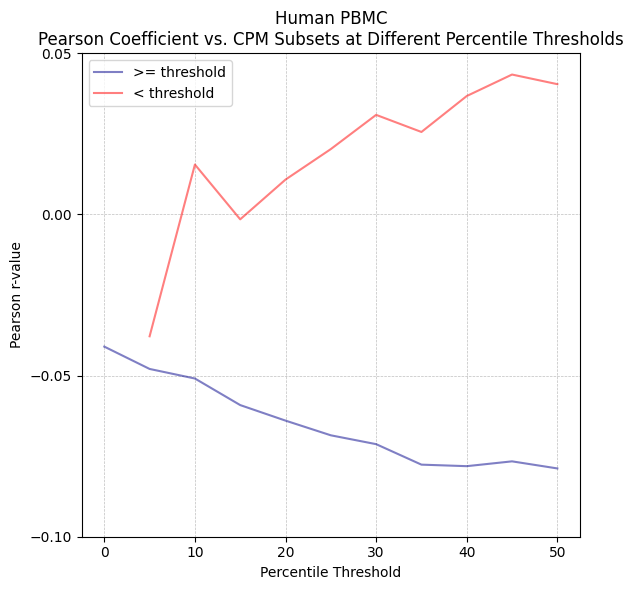

In [60]:
x_data = np.log2(pbmc_merged['Length'])
y_data = np.log2(pbmc_merged['cpm'] + 1)

# Initialize lists to store r-values
r_values_above_threshold = []
r_values_below_threshold = []

# Define percentile thresholds instead of fixed CPM thresholds
percentile_thresholds = np.arange(0, 51, 5)  # Thresholds from 0th to 50th percentile, in steps of 5%

for percentile in percentile_thresholds:
    threshold = np.percentile(y_data, percentile)

    # Data above the percentile threshold
    x_data_above = x_data[y_data >= threshold]
    y_data_above = y_data[y_data >= threshold]

    # Pearson's coefficient for the subset above the threshold
    if len(x_data_above) > 0 and len(y_data_above) > 0:
        r_value_above, _ = pearsonr(x_data_above, y_data_above)
    else:
        r_value_above = np.nan

    r_values_above_threshold.append(r_value_above)
    
    # Data below the percentile threshold
    x_data_below = x_data[y_data < threshold]
    y_data_below = y_data[y_data < threshold]

    # Pearson's coefficient for the subset below the threshold
    if len(x_data_below) > 0 and len(y_data_below) > 0:
        r_value_below, _ = pearsonr(x_data_below, y_data_below)
    else:
        r_value_below = np.nan

    r_values_below_threshold.append(r_value_below)

# Plot
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(percentile_thresholds, r_values_above_threshold, color='darkblue', alpha=0.5, label='>= threshold')
ax.plot(percentile_thresholds, r_values_below_threshold, color='red', alpha=0.5, label='< threshold')

ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
ax.set_xlabel('Percentile Threshold')
ax.set_ylabel('Pearson r-value')

all_r_values = r_values_above_threshold + r_values_below_threshold
ax.set_yticks(np.arange(np.floor(np.nanmin(all_r_values) * 10) / 10,
                        np.ceil(np.nanmax(all_r_values) * 10) / 10,
                        step=0.05))
ax.set_title('Human PBMC\nPearson Coefficient vs. CPM Subsets at Different Percentile Thresholds')
ax.legend()
plt.tight_layout()
plt.show()